# Analysis of results from fast Sodium channel ABC calibration

This notebook compares the behaviour of the $I_\text{Na}$ current in Nygren, Courtemanche and standardised formulations.

In [58]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

from typing import List

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyabc import History
from pyabc.weighted_statistics import weighted_mean, weighted_median

import myokit

import pymc3

from ionchannelABC.visualization import plot_variables
from ionchannelABC.utils import weighted_cv

## Load pyABC results databases for each run

Assumes that the results databases are stored in a subdirectory called `results'.

Loads history files and converts to dataframes and weights (see pyABC documentation).

In [59]:
def print_results_table(h: History,
                        modelname: str,
                        h_orig: History=None,
                        round_n: int=4,
                        credible_interval: float=0.89,
                        bootstrap_n: int=10000,
                        original: bool=True):
    round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))    
    round_fn = lambda x: round_to_n(x, round_n)
    
    # load df, w for unified and original (if supplied)
    df, w = h.get_distribution()
    if h_orig is not None:
        df_orig, w_orig = h_orig.get_distribution()
    
    params = []
    if original:
        originals = []
    medians = []
    medians_orig = []
    hpd = []
    hpd_orig = []
    rsd = []
    rsd_orig = []

    m = myokit.load_model(modelname)
    
    # need to bootstrap with weights to calculate weighted mean and HPD
    samples = df.sample(n=bootstrap_n, weights=w, replace=True)
    samples = samples.set_index([pd.Index(range(bootstrap_n))])
    
    samples_orig = pd.DataFrame()
    if h_orig is not None:
        samples_orig = df_orig.sample(n=bootstrap_n, weights=w_orig, replace=True)
        samples_orig = samples_orig.set_index([pd.Index(range(bootstrap_n))])
    
    for name in samples.columns:
        params.append(name.split('.')[1])
        if name.startswith('log_'):
            if original:
                originals.append(m.get(name[4:]).value())
            medians.append((10**(samples[name])).median())
            hpd.append(tuple(pymc3.stats.hpd(10**(samples[name]),
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append((10**(samples_orig[name])).median())
                hpd_orig.append(tuple(pymc3.stats.hpd(10**(samples_orig[name]),
                                                      credible_interval=credible_interval)))
        else:
            if original:
                originals.append(m.get(name).value())
            medians.append(samples[name].median())
            hpd.append(tuple(pymc3.stats.hpd(samples[name],
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append(samples_orig[name].median())
                hpd_orig.append(tuple(pymc3.stats.hpd(samples_orig[name],
                                                      credible_interval=credible_interval)))
    rsd = weighted_cv(df, w, sample_size=len(df))
    if h_orig is not None:
        rsd_orig = weighted_cv(df_orig, w_orig, sample_size=len(df_orig))
        
    for i, hpd_tuple in enumerate(hpd):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd[i] = round_tuple
    for i, hpd_tuple in enumerate(hpd_orig):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd_orig[i] = round_tuple
        
    out_dict = {'Name': params}
    if original:
        out_dict = {**out_dict, 'Published': originals}
    if h_orig is not None:
        out_dict = {**out_dict, 'Median (orig)': medians_orig,
                                'HPD'+str(int(credible_interval*100))+' (orig)': hpd_orig,
                                '$log_{10}$RSD (orig)': rsd_orig}
    out_dict = {**out_dict, 'Median (unif)': medians,
                            'HPD'+str(int(credible_interval*100))+' (unif)': hpd,
                            '$log_{10}$RSD (unif)': rsd}
    out_df = pd.DataFrame(out_dict)
    if original:
        out_df['Published'] = out_df['Published'].map(round_fn)
    out_df['Median (unif)'] = out_df['Median (unif)'].map(round_fn)
    out_df['$log_{10}$RSD (unif)'] = np.log10(out_df['$log_{10}$RSD (unif)']).map(round_fn)
    if h_orig is not None:
        out_df['Median (orig)'] = out_df['Median (orig)'].map(round_fn)
        out_df['$log_{10}$RSD (orig)'] = np.log10(out_df['$log_{10}$RSD (orig)']).map(round_fn)

    print(out_df.to_csv(sep='\t', index=False))

#### Nygren

In [60]:
h_nyg_original = History('sqlite:///results/nygren/ina/original/nygren_ina_original.db')

In [61]:
df_nyg_original, w_nyg_original = h_nyg_original.get_distribution(m=0)

In [62]:
h_nyg_unified = History('sqlite:///results/nygren/ina/unified/nygren_ina_unified.db')

In [63]:
df_nyg_unified, w_nyg_unified = h_nyg_unified.get_distribution(m=0)

In [64]:
print_results_table(h_nyg_unified, 'models/nygren_ina.mmt', h_orig=h_nyg_original)

Name	Published	Median (orig)	HPD89 (orig)	$log_{10}$RSD (orig)	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
q1	63.6	95.58	(95.08, 96.11)	-2.465	93.98	(88.04, 99.25)	-1.4
q2	5.3	6.495	(6.092, 6.86)	-1.432	8.195	(1.222, 13.13)	-0.3487
q4	35.1	35.16	(0.01994, 149.8)	-0.02249	53.59	(48.78, 57.59)	-1.263
q5	3.2	12.86	(4.701, 19.98)	-0.361	10.56	(7.184, 13.27)	-0.7463
r1	27.12	52.26	(50.95, 53.54)	-1.795	42.84	(33.91, 55.2)	-0.7966
r2	8.21	10.68	(9.788, 11.61)	-1.256	12.98	(7.43, 19.67)	-0.5127
r4	25.57	57.59	(22.93, 99.8)	-0.3404	56.92	(16.97, 99.79)	-0.293
r5	28.8	10.07	(0.2856, 17.87)	-0.2282	9.289	(0.001354, 17.53)	-0.1981
s1	0.9	0.5003	(0.1081, 0.9909)	-0.2317	0.4707	(0.1367, 0.8249)	-0.334
q3	0.03	0.0973	(0.001002, 0.4495)	-0.1696	0.004108	(0.002387, 0.0253)	-0.7312
q6	0.0003	0.0002431	(1.002e-05, 0.004357)	-0.6137	0.0002377	(1.008e-05, 0.001568)	-0.7811
q7	0.12	0.07166	(0.001005, 0.3936)	-0.1983	0.02022	(0.002594, 0.02733)	-0.6835
q8	0.003	0.002186	(0.0001009, 0.04721)	-0.4589	0.00

In [65]:
len(df_nyg_unified)

10000

#### Courtemanche

In [30]:
# For Courtemanche original and unified are the same.
h_cou_m_original = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_mgate_original.db')
h_cou_h_original = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_hgate_original.db')
h_cou_j_original = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_jgate_original.db')

In [31]:
df_cou_m_original, w_cou_m_original = h_cou_m_original.get_distribution(m=0)
df_cou_h_original, w_cou_h_original = h_cou_h_original.get_distribution(m=0)
df_cou_j_original, w_cou_j_original = h_cou_j_original.get_distribution(m=0)

In [32]:
print_results_table(h_cou_m_original, 'models/courtemanche_ina.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
a1_m	-47.13	-76.02	(-79.77, -73.65)	-1.586
a2_m	0.32	0.2637	(0.2476, 0.2741)	-1.476
a3_m	0.1	0.3355	(0.1927, 0.7643)	-0.2765
a4_m	3.2	4.798	(1.786, 9.998)	-0.2421
b1_m	0.08	1.264	(1.224, 1.322)	-1.64
b2_m	11.0	23.2	(22.77, 24.04)	-1.774



In [33]:
print_results_table(h_cou_h_original, 'models/courtemanche_ina.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
a2_h	6.8	15.49	(14.49, 16.01)	-1.465
a3_h	80.0	122.5	(67.51, 155.4)	-0.6085
b2_h	10.66	18.27	(5.525, 31.86)	-0.3218
b3_h	11.1	16.75	(12.43, 21.47)	-0.7582
c1_h	-40.0	-37.27	(-46.51, -33.19)	-0.8902
a1_h	0.135	0.3925	(0.01107, 3.35)	0.269
b4_h	3.56	15.11	(14.51, 15.79)	-1.999
b5_h	0.079	0.05808	(0.05716, 0.05891)	-2.492
b6_h	310000.0	20190.0	(1002.0, 321300.0)	-0.6777
b7_h	0.35	1.327	(0.2776, 6.36)	0.4741



In [34]:
print_results_table(h_cou_j_original, 'models/courtemanche_ina.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
a6_j	0.311	0.4432	(0.0001592, 0.8758)	-0.2087
a7_j	79.23	41.98	(3.962, 91.36)	-0.1966
b3_j	0.1	0.4522	(6.276e-05, 0.8639)	-0.1977
b4_j	32.0	67.64	(22.1, 99.95)	-0.3641
b5_j	0.1212	0.3527	(0.04546, 0.7968)	-0.1691
b7_j	0.1378	0.2615	(0.002616, 0.7761)	-0.09422
b8_j	40.14	72.86	(31.34, 99.65)	-0.4359
c1_j	-40.0	-32.27	(-74.3, -1.108)	-0.179
a1_j	127100.0	122700.0	(1198.0, 4778000.0)	-0.6361
a2_j	0.2444	5.305	(0.1528, 50.75)	0.02476
a3_j	3.474e-05	0.0003834	(1.092e-05, 0.001184)	-0.7783
a4_j	0.04391	0.003618	(0.0001008, 0.02863)	-0.5131
b6_j	0.01052	0.001623	(0.0001004, 0.01871)	-0.5618



#### Standardised

In [35]:
h_sta = History('sqlite:///results/standardised/ina/standardised_ina_unified.db')

In [36]:
df_sta, w_sta = h_sta.get_distribution(m=0)

In [37]:
print_results_table(h_sta, 'models/standardised_ina.mmt', original=False)

Name	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p_2	0.1255	(0.1003, 0.1463)	-0.9488
p_4	0.0234	(8.432e-05, 0.04017)	-0.2237
p_6	0.0441	(0.04208, 0.04601)	-1.523
p_8	0.04053	(0.03864, 0.04302)	-1.44
A	4.197	(4.048, 4.314)	-1.869
p_1	5134.0	(1620.0, 9786.0)	-1.241
p_3	3.292	(0.5749, 6.057)	-0.2008
p_5	6.091	(5.591, 6.693)	-1.495
p_7	0.005379	(0.004081, 0.006667)	-1.496



## Compare number of gating parameters in models

Generate bar plot using manually input numbers. See models and publications for source.

In [16]:
parameter_number = pd.DataFrame([['N',6,9],['C',6,23],['S',4,5]], 
                                columns = ['model', 'act', 'inact'])

In [17]:
# Hack to let different shading work in plotting
parameter_number.inact = parameter_number.act + parameter_number.inact

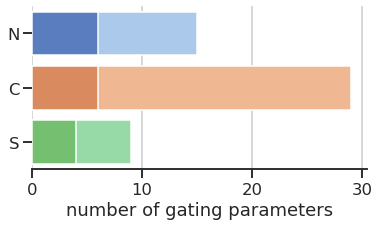

In [18]:
sns.set(style="ticks")
sns.set_context("talk")
sns.set_color_codes("pastel")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="inact", y="model", hue="model", data=parameter_number,
            palette="pastel", dodge=False)

sns.set_color_codes("muted")
sns.barplot(x="act", y="model", hue="model", data=parameter_number,
            palette="muted", dodge=False)

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(xlabel="number of gating parameters")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(left=True)

In [19]:
#f.savefig('figures/ina/param_num_compare.pdf')

## Compare calibration between original and unified datasets

Plot relative standard deviation (RSD) of parameter posteriors and gating functions for Nygren and Courtemanche using the original dataset and unified datasets.

Note: we use the term RSD instead of CV (coefficient of variation) to avoid confusion with conduction velocity.

#### Calculate RSD values for Nygren and Courtemanche models

In [16]:
rsd_nyg_original = weighted_cv(df_nyg_original, 
                               w_nyg_original, 
                               sample_size=len(df_nyg_original))

model = ['N',]*len(rsd_nyg_original)
data = ['ORIGINAL',]*len(rsd_nyg_original)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_original}
nyg_original = pd.DataFrame(frame)

In [17]:
rsd_nyg_unified = weighted_cv(df_nyg_unified, 
                              w_nyg_unified, 
                              sample_size=len(df_nyg_unified))

model = ['N',]*len(rsd_nyg_unified)
data = ['UNIFIED',]*len(rsd_nyg_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_unified}
nyg_unified = pd.DataFrame(frame)

In [18]:
rsd_cou_m = weighted_cv(df_cou_m_original, 
                        w_cou_m_original, 
                        sample_size=len(df_cou_m_original))
rsd_cou_h = weighted_cv(df_cou_h_original, 
                        w_cou_h_original, 
                        sample_size=len(df_cou_h_original))
rsd_cou_j = weighted_cv(df_cou_j_original, 
                        w_cou_j_original, 
                        sample_size=len(df_cou_j_original))

rsd_cou_original = pd.concat([rsd_cou_m, rsd_cou_h, rsd_cou_j])
model = ['C',]*len(rsd_cou_original)
data = ['ORIGINAL',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_original = pd.DataFrame(frame)

In [19]:
# Courtemanche uses same original and unified datasets.
data = ['UNIFIED',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_unified = pd.DataFrame(frame)

In [20]:
rsd_compare = pd.concat([nyg_original, nyg_unified, cou_original, cou_unified], sort=False)

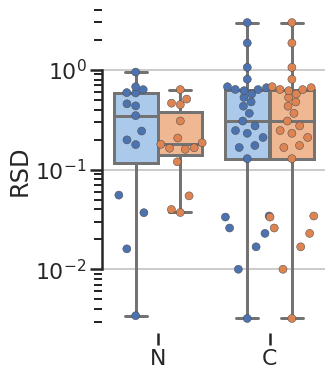

In [21]:
sns.set(style="ticks")
sns.set_context("poster")

# Initialize the figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the boxplot summary of RSD
sns.boxplot(x="model", y="RSD", hue="data", data=rsd_compare,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="model", y="RSD", hue="data", data=rsd_compare,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set_yscale('log')
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)
ax.get_legend().remove()

In [26]:
diff = nyg_unified.RSD-nyg_original.RSD
stats.wilcoxon(diff)

WilcoxonResult(statistic=38.0, pvalue=0.21147639221681047)

In [27]:
stats.mannwhitneyu(rsd_compare[(rsd_compare.model=='N') & (rsd_compare.data=='ORIGINAL')].RSD, 
                   rsd_compare[(rsd_compare.model=='C') & (rsd_compare.data=='ORIGINAL')].RSD)

MannwhitneyuResult(statistic=209.0, pvalue=0.42149318149179993)

In [28]:
stats.mannwhitneyu(rsd_compare[(rsd_compare.model=='N') & (rsd_compare.data=='UNIFIED')].RSD, 
                   rsd_compare[(rsd_compare.model=='C') & (rsd_compare.data=='UNIFIED')].RSD)

MannwhitneyuResult(statistic=170.0, pvalue=0.12227467240427337)

In [29]:
#f.savefig('figures/ina/rsd_compare.pdf')

#### Compare underlying gating functions for each model

Sample from posterior particle population and plot resulting gating functions

In [31]:
# Number of samples
N = 100

In [32]:
nyg_par_samples_original = df_nyg_original.sample(n=N, weights=w_nyg_original, replace=True)
nyg_par_samples_original = nyg_par_samples_original.set_index([pd.Index(range(N))])
nyg_par_samples_original = nyg_par_samples_original.to_dict(orient='records')

In [33]:
nyg_par_samples_unified = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples_unified = nyg_par_samples_unified.set_index([pd.Index(range(N))])
nyg_par_samples_unified = nyg_par_samples_unified.to_dict(orient='records')

In [16]:
# Voltage range to plot gating functions over
v = np.arange(-140, 50, 0.5)

# Mapping an id to the parameter name in the mmt modelfile
nyg_par_map = {'mi': 'ina.m_ss',
               'mt': 'ina.tau_m',
               'hi': 'ina.h_ss',
               'ht': 'ina.tau_h1',
               'ji': 'ina.h_ss',
               'jt': 'ina.tau_h2'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


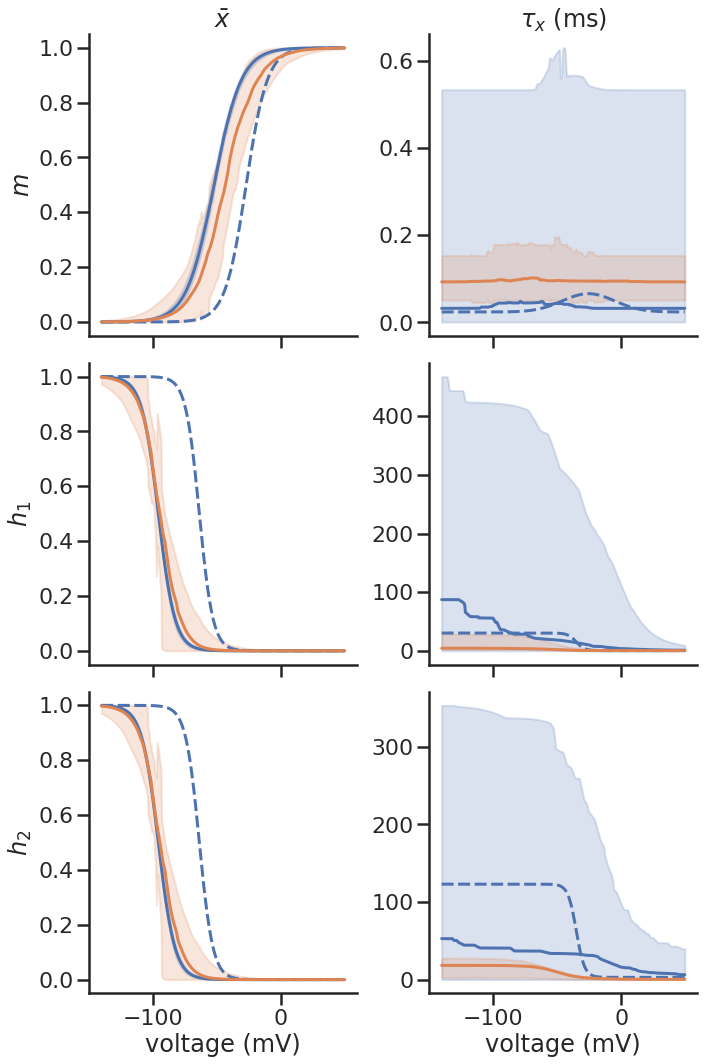

In [35]:
sns.set_context("poster")
sns.set_palette("deep")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plot_variables(v, 
                       [nyg_par_map, nyg_par_map], 
                       # The models only differ in the `name' metadata to separate their output when plotting.
                       ['models/nygren_ina.mmt', 'models/nygren_ina_.mmt'],
                       [nyg_par_samples_original, nyg_par_samples_unified],
                       original=[True,False],
                       figshape=(2,3))

ax[0][0].set_ylabel(r'$m$')
ax[1][0].set_ylabel(r'$h_1$')
ax[2][0].set_ylabel(r'$h_2$')
ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')
for a in ax[:,1].flatten():
    a.set_ylabel('')    
for a in ax[2][:]:
    a.set_xlabel('voltage (mV)')
    
plt.tight_layout()

In [36]:
#f.savefig('figures/ina/nyg_gating_functions.pdf')

In [37]:
cou_par_samples_m = df_cou_m_original.sample(n=N, weights=w_cou_m_original, replace=True)
cou_par_samples_m = cou_par_samples_m.set_index([pd.Index(range(N))])
cou_par_samples_h = df_cou_h_original.sample(n=N, weights=w_cou_h_original, replace=True)
cou_par_samples_h = cou_par_samples_h.set_index([pd.Index(range(N))])
cou_par_samples_j = df_cou_j_original.sample(n=N, weights=w_cou_j_original, replace=True)
cou_par_samples_j = cou_par_samples_j.set_index([pd.Index(range(N))])

cou_par_samples = (pd.concat([cou_par_samples_m, cou_par_samples_h, cou_par_samples_j], axis=1)
                   .to_dict(orient='records'))

In [17]:
cou_par_map = {'mi': 'ina.m_inf',
               'mt': 'ina.tau_m',
               'hi': 'ina.h_inf',
               'ht': 'ina.tau_h',
               'ji': 'ina.j_inf',
               'jt': 'ina.tau_j'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


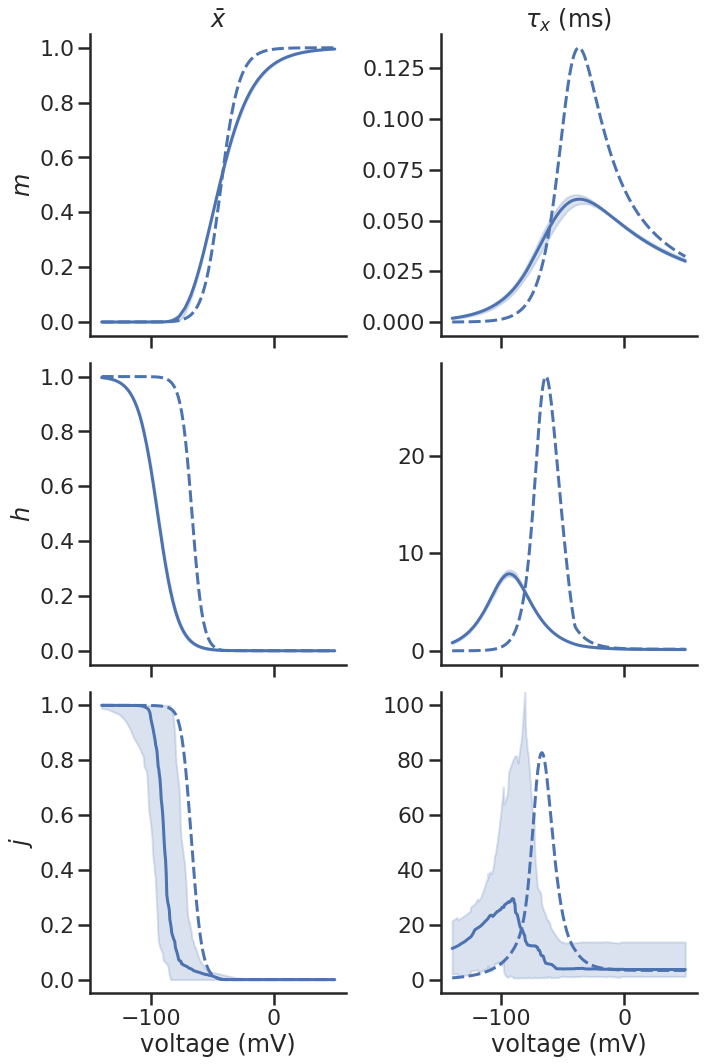

In [39]:
sns.set_context("poster")
sns.set_palette("deep")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plot_variables(v, cou_par_map, 
                       ["models/courtemanche_ina.mmt"], 
                       [cou_par_samples],
                       original=True,
                       figshape=(2,3))

ax[0][0].set_ylabel(r'$m$')
ax[1][0].set_ylabel(r'$h$')
ax[2][0].set_ylabel(r'$j$')
ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')
for a in ax[:,1].flatten():
    a.set_ylabel('')
for a in ax[:,0].flatten():
    a.set_ylim((-0.05, 1.05))    
ax[2,1].set_ylim((100*-0.05, 100*1.05))    
for a in ax[2][:]:
    a.set_xlabel('voltage (mV)')
    
plt.tight_layout()

In [41]:
#f.savefig('figures/ina/cou_gating_functions.pdf')

## Compare all models calibrated to unified dataset

### RSD of parameter posteriors

In [42]:
rsd_sta = weighted_cv(df_sta, w_sta, sample_size=len(df_sta))
model = ['S',]*len(rsd_sta)
frame = {'model': model, 'RSD': rsd_sta}
sta = pd.DataFrame(frame)

In [43]:
rsd_unified = pd.concat([nyg_unified, cou_unified, sta], sort=False)

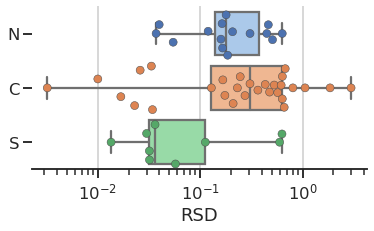

In [44]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x="RSD", y="model", data=rsd_unified,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="RSD", y="model", data=rsd_unified,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set_xscale("log")
ax.set(ylabel="")
sns.despine(left=True)

In [46]:
#f.savefig('figures/ina/rsd_compare_unified.pdf')

In [47]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=34.0, pvalue=0.024548990804632777)

In [48]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='C'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=79.0, pvalue=0.0399652826961548)

In [49]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='C'].RSD)

MannwhitneyuResult(statistic=170.0, pvalue=0.12227467240427337)

### Residuals to experimental data

In [38]:
# Sample number
N = 100

In [39]:
eps_nyg = h_nyg_unified.get_weighted_distances()
eps_nyg = eps_nyg.sample(n=N, axis=0, weights=eps_nyg.w, replace=True).distance
eps_nyg = pd.DataFrame({'model': 'N', 'eps': eps_nyg, 'exp': 'all'})

In [40]:
eps_cou_m = h_cou_m_original.get_weighted_distances()
eps_cou_h = h_cou_h_original.get_weighted_distances()
eps_cou_j = h_cou_j_original.get_weighted_distances()

eps_cou = np.array([])
eps_cou = (np.array(eps_cou_m.sample(n=N, axis=0, weights=eps_cou_m.w, replace=True).distance) +
           np.array(eps_cou_h.sample(n=N, axis=0, weights=eps_cou_h.w, replace=True).distance) +
           np.array(eps_cou_j.sample(n=N, axis=0, weights=eps_cou_j.w, replace=True).distance))

frame = {'model': 'C', 'eps': eps_cou, 'exp': 'all'}
eps_cou = pd.DataFrame(frame)

In [41]:
eps_sta = h_sta.get_weighted_distances()

eps_sta = eps_sta.sample(n=N, axis=0, weights=eps_sta.w, replace=True).distance
eps_sta = pd.DataFrame({'model': 'S', 'eps': eps_sta, 'exp': 'all'})

In [42]:
eps = pd.concat([eps_nyg, eps_cou, eps_sta])

In [43]:
eps['normalised'] = (eps['eps']-eps['eps'].min())/(eps['eps'].max()-eps['eps'].min())

Text(0, 0.5, 'residual')

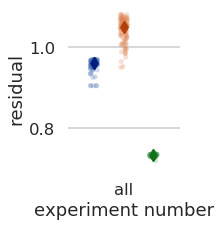

In [44]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(2, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=eps, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=eps,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.get_legend().remove()
ax.set_xlabel('experiment number')
ax.set_ylabel('residual')

In [63]:
#f.savefig('figures/ina/eps_all_stripplot.pdf')

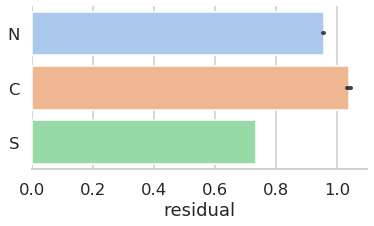

In [45]:
sns.set_context('talk')

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="eps", y="model", data=eps, palette='pastel')

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="residual")
sns.despine(left=True)

In [51]:
epsN = eps[eps['model']=='N'].median()

In [52]:
epsC = eps[eps['model']=='C'].median()

In [53]:
epsS = eps[eps['model']=='S'].median()

In [54]:
(epsC-epsS)/epsC

eps           0.300493
normalised    0.957278
dtype: float64

In [57]:
(epsN-epsS)/epsN

eps           0.235113
normalised    0.941291
dtype: float64

In [59]:
#f.savefig('figures/ina/eps_all_barplot.pdf')

Below we sample from the posterior particle populations and run the calibration experiments to be able to calculate a per-experiment epsilon value.

In [64]:
nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_m = df_cou_m_original.sample(n=N, weights=w_cou_m_original, replace=True)
cou_par_samples_m = cou_par_samples_m.set_index([pd.Index(range(N))])
cou_par_samples_m = cou_par_samples_m.to_dict(orient='records')

cou_par_samples_h = df_cou_h_original.sample(n=N, weights=w_cou_h_original, replace=True)
cou_par_samples_h = cou_par_samples_h.set_index([pd.Index(range(N))])
cou_par_samples_h = cou_par_samples_h.to_dict(orient='records')

cou_par_samples_j = df_cou_j_original.sample(n=N, weights=w_cou_j_original, replace=True)
cou_par_samples_j = cou_par_samples_j.set_index([pd.Index(range(N))])
cou_par_samples_j = cou_par_samples_j.to_dict(orient='records')

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

In [65]:
from ionchannelABC.experiment import setup
from ionchannelABC.distance import IonChannelDistance

In [66]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)
experiments = [sakakibara_act, 
               schneider_taum, 
               sakakibara_inact, 
               sakakibara_inact_kin_fast,
               sakakibara_inact_kin_slow,
               sakakibara_rec_fast,
               sakakibara_rec_slow]
models = ['models/nygren_ina_temp_adj.mmt',
          'models/courtemanche_ina.mmt',
          'models/standardised_ina.mmt']
par_samples = [nyg_par_samples, [cou_par_samples_m, cou_par_samples_h, cou_par_samples_j], std_par_samples]
names = ['N','C','S']

In [67]:
def experiment_dist(pars, modelfile, experiment):
    eps = []
    observ, model, sum_stats = setup(modelfile,
                                     experiment)
    obs = observ.to_dict()['y']
    obs = {str(k): v for k, v in obs.items()}
    dist = IonChannelDistance(exp_id=list(observ.exp_id),
                              variance=list(observ.variance),
                              delta=0.05)
    for sample in pars:
        eps.append(dist(sum_stats(model(sample)), obs, None))    
    return eps

The below cell calculates the per-experiment distance and may take some time to run depending on number of samples.

In [70]:
df = pd.DataFrame({})
mask = [None, [0, 0, 1, 1, 2, 1, 2], None] # Required to use correct samples for the Courtemanche model experiments

for j, exp in enumerate(experiments):
    df_ = pd.DataFrame({})
    for i, m in enumerate(models):
        if mask[i] is not None:
            eps = np.array(
                experiment_dist(par_samples[i][mask[i][j]],
                                m,
                                exp)
                )
        else:
            eps = np.array(
                experiment_dist(par_samples[i],
                                m,
                                exp)
                )
        df_ = df_.append(pd.DataFrame({'model': names[i],
                                       'exp': str(j),
                                       'eps': eps[~np.isinf(eps)]}))
    eps_max = df_['eps'].max()
    eps_min = df_['eps'].min()
    df_['eps'] = (df_['eps'] - eps_min)/(eps_max-eps_min)
    df = df.append(df_)

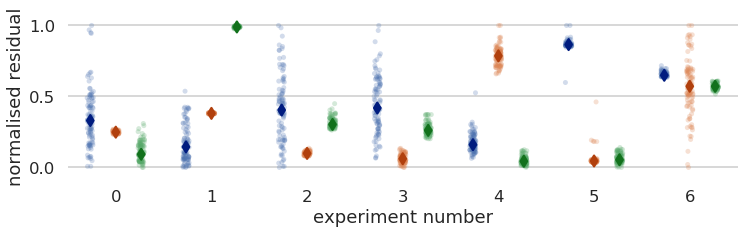

In [71]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

fig, ax = plt.subplots(figsize=(12, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=df, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=df,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="model",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')
ax.get_legend().remove()

In [84]:
#fig.savefig('figures/ina/eps_per_exp_stripplot.pdf')

### Summary statistics compared to experimental data

In [16]:
from ionchannelABC.visualization import plot_sim_results

In [17]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)

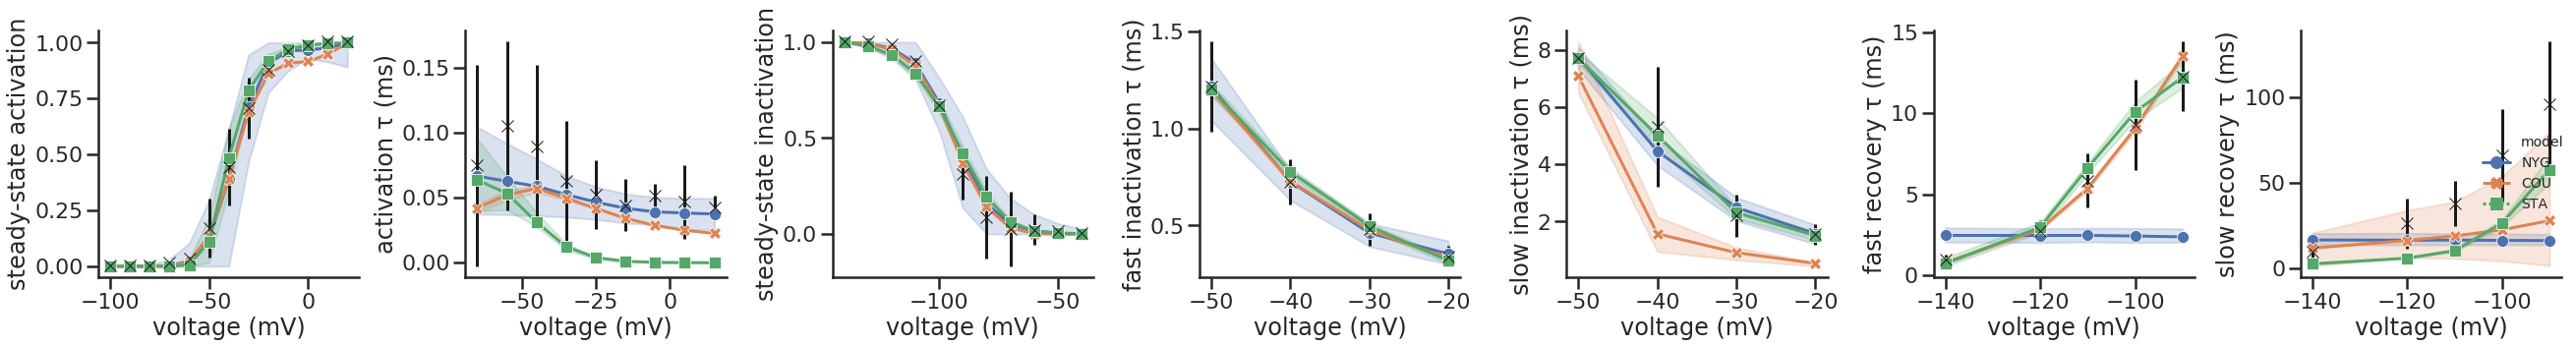

In [18]:
sns.set(style="ticks")
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/standardised_ina.mmt'],
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_fast,
                     sakakibara_rec_slow,
                     temp_match_model=4, # scale all results to temperature of S model
                     masks=[None,
                            [0,1]+[None,]*5,
                            [None,]*2+[2,3,None,5,None],
                            [None,]*4+[4,None,6],
                            None],
                     df=[df_nyg_unified,
                         df_cou_m_original,
                         df_cou_h_original,
                         df_cou_j_original,
                         df_sta], 
                     w=[w_nyg_unified,
                        w_cou_m_original,
                        w_cou_h_original,
                        w_cou_j_original,
                        w_sta])

ylabels = ["steady-state activation", "activation τ (ms)", "steady-state inactivation",
           "fast inactivation τ (ms)", "slow inactivation τ (ms)", "fast recovery τ (ms)", 
           "slow recovery τ (ms)"]

for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [20]:
#g.savefig('figures/ina/compare_summary_statistics.pdf')

### Gating functions compared between models

In [18]:
nyg = 'models/nygren_ina_temp_adj.mmt' # Adjusted to same temperature using Q10=2.79
cou ='models/courtemanche_ina.mmt'
std = 'models/standardised_ina.mmt'

In [19]:
v = np.arange(-140, 50, 0.5)

In [24]:
# Mapping an id to the parameter name in the mmt modelfile
nyg_par_map = {'mi': 'ina.m_ss',
               'hi': 'ina.h_ss',
               'ji': 'ina.h_ss',
               'mt': 'ina.tau_m',
               'ht': 'ina.tau_h1',
               'jt': 'ina.tau_h2'}

cou_par_map = {'mi': 'ina.m_inf',
               'hi': 'ina.h_inf',
               'ji': 'ina.j_inf',
               'mt': 'ina.tau_m',
               'ht': 'ina.tau_h',
               'jt': 'ina.tau_j'}

std_par_map = {'mi': 'ina.m_ss',               
               'hi': 'ina.h_ss',
               'ji': 'ina.h_ss',
               'mt': 'ina.tau_m',
               'ht': 'ina.tau_h1',
               'jt': 'ina.tau_h2'}

In [25]:
N = 100

nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_m = df_cou_m_original.sample(n=N, weights=w_cou_m_original, replace=True)
cou_par_samples_m = cou_par_samples_m.set_index([pd.Index(range(N))])
cou_par_samples_h = df_cou_h_original.sample(n=N, weights=w_cou_h_original, replace=True)
cou_par_samples_h = cou_par_samples_h.set_index([pd.Index(range(N))])
cou_par_samples_j = df_cou_j_original.sample(n=N, weights=w_cou_j_original, replace=True)
cou_par_samples_j = cou_par_samples_j.set_index([pd.Index(range(N))])
cou_par_samples = (pd.concat([cou_par_samples_m, cou_par_samples_h, cou_par_samples_j], axis=1)
                   .to_dict(orient='records'))

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

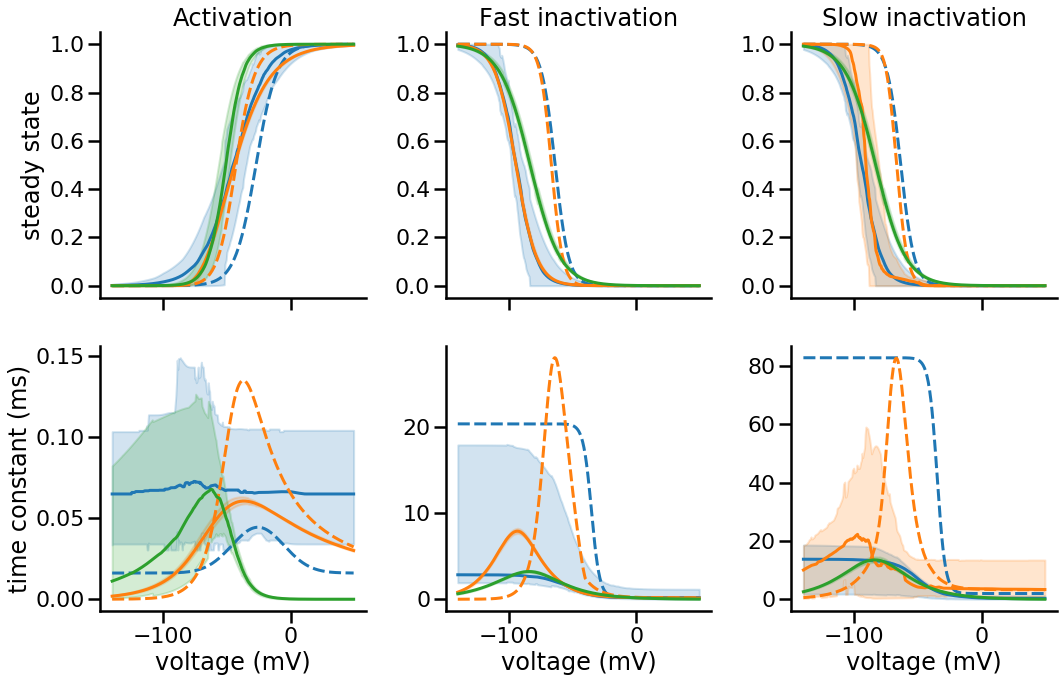

In [32]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, 
                       [nyg_par_map, cou_par_map, std_par_map], 
                       [nyg, cou, std], 
                       [nyg_par_samples, cou_par_samples, std_par_samples],
                       original=[True, True, False],
                       figshape=(3,2))

ax[0][0].set_ylabel('steady state')
ax[1][0].set_ylabel('time constant (ms)')
ax[0][0].set_title('Activation')
ax[0][1].set_title('Fast inactivation')
ax[0][2].set_title('Slow inactivation')

for a in ax[0,:]:
    a.set_ylim((-0.05, 1.05))

for a in ax[:,1:].flatten():
    a.set_ylabel('')
    
for a in ax[1,:]:
    a.set_xlabel('voltage (mV)')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [34]:
#f.savefig('figures/ina/compare_gating_functions.pdf')

### Compare final pulse after pulse train

In [31]:
import myokit

nsteps = 100
period = 1000
tstep = 100
vhold = -140
vstep = -30

pulsetrain = myokit.pacing.steptrain([vstep,]*nsteps,
                                     vhold,
                                     period-tstep,
                                     tstep)

In [32]:
# nygren_ina_full has had tau values adjusted for temperature to 310K
models = [myokit.load_model(modelfile) for modelfile in ['models/nygren_ina_temp_adj.mmt',
                                                         'models/courtemanche_ina.mmt',
                                                         'models/standardised_ina.mmt']]
for m in models:
    pace = m.get('membrane.V')
    if pace.binding() != 'pace':
        if pace.is_state():
            pace.demote()
        pace.set_rhs(0)
        pace.set_binding('pace')

In [33]:
sims = [myokit.Simulation(m, pulsetrain) for m in models]

In [34]:
# Use parameter samples generated in previous section
par_samples = [nyg_par_samples, cou_par_samples, std_par_samples]

In [35]:
import time

all_samples = pd.DataFrame({})
for i, s in enumerate(sims):
    s.reset()
    # store original
    if models[i].name() != 'STA':
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ina.g','engine.time','membrane.V'],
                        log_interval=0.2)
        datalog = datalog.trim(9890, 9930, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ina.g']/max(datalog['ina.g']),
              'sample': 0,
              'model': models[i].name(),
              'type': 'original'}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)
    
    # re-calibrated
    for j, par_sample in enumerate(par_samples[i]):
        s.reset()
        for p, v in par_sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            s.set_constant(name, value)
            
        # Log run time for comparisons
        t0 = time.time()
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ina.g','engine.time','membrane.V'],
                        log_interval=0.2)
        t1 = time.time()
        dt = t1-t0
        
        datalog = datalog.trim(9890, 9930, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ina.g']/max(datalog['ina.g']),
              'sample': j,
              'model': models[i].name(),
              'type': 'recalibrated',
              'runtime': dt}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [36]:
recalibrated_df = all_samples[all_samples['type']=='recalibrated']

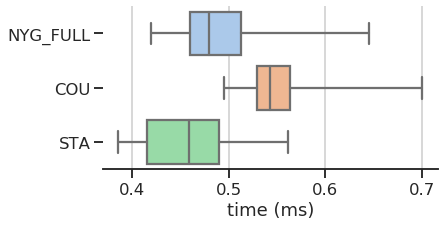

In [37]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x='runtime', y='model', data=recalibrated_df,
            palette="pastel", whis="range")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="time (ms)")
sns.despine(left=True)

In [39]:
#f.savefig('figures/ina/runtime_compare.pdf')

In [40]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='STA'].runtime, 
                   recalibrated_df[recalibrated_df.model=='COU'].runtime,
                   alternative='two-sided')

MannwhitneyuResult(statistic=12240000.0, pvalue=0.0)

In [41]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='COU'].runtime, 
                   recalibrated_df[recalibrated_df.model=='NYG'].runtime,
                   alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [42]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='STA'].runtime, 
                   recalibrated_df[recalibrated_df.model=='NYG'].runtime,
                   alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [43]:
all_samples_detail = all_samples[(all_samples['time']>=9.8) & (all_samples['time'] < 12)]

Text(0.5, 1.0, '')

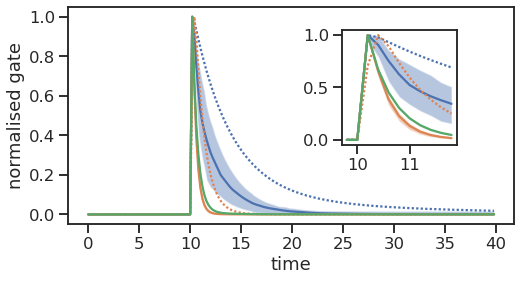

In [44]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(8,4))

g = sns.lineplot(x='time', y='gate', hue='model', style='type',
                 dashes = [(1,1),''],
                 data=all_samples, ax=ax,
                 estimator=np.median,
                 ci=None,
                 legend=False)
data = all_samples
for model in data['model'].unique():
    hpd = np.zeros((len(data['time'].unique()), 2))
    for j, tj in enumerate(data['time'].unique()):
        data_tj = data[(data['time']==tj) & (data['model']==model) & (data['type']=='recalibrated')]
        hpd[j,:] = pymc3.hpd(data_tj['gate'], credible_interval=0.89)
    ax.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1], alpha=0.4)

ax2 = plt.axes([.6, .4, .2, .4])
sns.lineplot(x='time',y='gate',hue='model',style='type',
             dashes=[(1,1),''],
             data=all_samples_detail, ax=ax2,
             estimator=np.median,
             ci=None,
             legend=False)
data = all_samples_detail
for model in data['model'].unique():
    hpd = np.zeros((len(data['time'].unique()), 2))
    for j, tj in enumerate(data['time'].unique()):
        data_tj = data[(data['time']==tj) & (data['model']==model) & (data['type']=='recalibrated')]
        hpd[j,:] = pymc3.hpd(data_tj['gate'], credible_interval=0.89)
    ax2.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1], alpha=0.4)
    
ax2.set_xlabel('')
ax2.set_ylabel('')

ax.set_ylabel('normalised gate')
ax.set_title('')

In [47]:
#f.savefig('figures/ina/trace_compare.pdf')